## Organoid simulation

This notebook is based on Mason's method to simulate organoids. It uses a stochastic model to determine which neurons will fire at t+1 based on neurons firing at t. See Mason's model description.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf
tf.enable_eager_execution()

/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Added inhibitory neurons to the total population: User can pick a proportion of inhibitory neurons which will be randomly picked in the neuron vector.

In the case of inhibitory neurons, neuron  $j$ firing at time  $t$ will cause neuron  $i$ to NOT fire at time  $t+1$. So we take the inverse of this probability so that in the product of $(1-p_{i,j})$ , inhibitory neurons firing will decrease the probability of neuron $i$ firing.

This simple model may need refinement as the biology of neuron inhibition is slightly different.

Also, we added a refractory period: if a neuron was firing at $t$, it won't be able to fire at $t+1$, no matter what the probability would have been.

## Model Initialization

In [6]:
# Number of neurons
neurons = 1000

# Proportion of inhibitory neurons in the neuron population
prop_inhib = 0.2

# Generates a boolean array determining which neurons are inhibitory.
inhib_idx = np.random.choice(neurons, int(prop_inhib*neurons))
inhib = np.zeros(neurons, dtype=np.bool)
inhib[inhib_idx] = True

# Probability matrix - initialize randomly. Hackily based on measuring 
# a DIFFERENT probability P(cell i fires after cell i) in the biophysical
# model and assuming that this is about 5 times less since about 5
# cells fire per timestep in that model.
probability_matrix = np.random.exponential(size=(neurons,neurons), scale=0.005)/5

# Neurons state - initialize randomly, 10% active before start.
initial_state = np.random.random(neurons) < 0.1

# Stimulate for t_stim, then measure for t_meas. Total simulation t_total.
t_stim = 1000
t_meas = 100
t_total = t_stim + t_meas

# Implement stimulation by making spontaneous firing rate a function of
# position. At the center of stimulation, cells fire spontaneously at
# about 100Hz, while at the periphery, spontaneous activity is about 1Hz.
n_probes = 8
mu = lambda stim_region: neurons/n_probes * (stim_region + 1/2)
sigma = neurons / n_probes / 10
def threshold(timestep, stim_region):
    return 1e-3 + 1e-1 * np.exp(-((np.arange(neurons) - mu(stim_region)) / sigma)**2) * (timestep < t_stim)

## Optimized version of next_state

In [7]:
def next_state(neurons, probability_matrix, previous_state, timestep, stim_region):
    """
    Get new state t+1 of active/inactive neurons by using probabilities of firing.
    
    Args:
        neurons (int): number of neurons to be simulated.
        probability_matrix (np.array): probability of neuron j firing at t causing neuron i to fire at t+1.
        previous_state (np.array): vector of neuron states at t .
        
    Returns:
        next_state (np.array): vector of neuron states at t+1.
    """
    # Probability that cell j will NOT affect cell i.
    # Restrict attention to cells that are firing.
    inh_prod = np.prod(1 - probability_matrix[:, inhib & previous_state], axis=1)
    exc_prod = np.prod(1 - probability_matrix[:, ~inhib & previous_state], axis=1)
    expectation_values = (1 - exc_prod) * inh_prod
    
    expectation_values[np.random.random(neurons) < threshold(timestep, stim_region)] = 1
    
    return (np.random.random(neurons) < expectation_values) & (previous_state==0)

In [8]:
%%time
states= np.zeros((t_total+1, neurons), dtype=np.bool)
states[0,:] = initial_state
for t in range(t_total):
    states[t+1,:] = next_state(neurons, probability_matrix, states[t,:], t, 1)

CPU times: user 285 ms, sys: 5.11 ms, total: 290 ms
Wall time: 287 ms


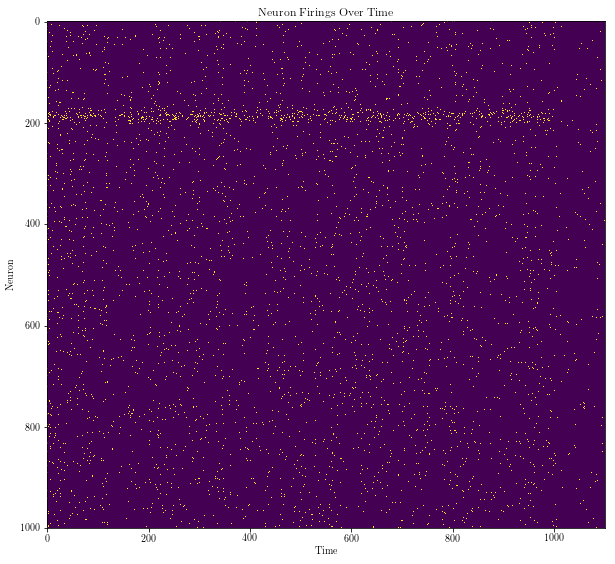

In [9]:
plt.figure(figsize=(10,20))
plt.imshow(states.T)
plt.xlabel("Time")
plt.ylabel("Neuron")
plt.title("Neuron Firings Over Time")
# plt.savefig('my-version.png')

# Create and Upload a Dataset to PRP S3.

In [ ]:
Npoints_train = 800
Npoints_test = 200
DATA_DIR = 'data/'
datafile_train = 'train.tfrecord'
datafile_test = 'test.tfrecord'

S3_PROTOCOL = 's3://'
HTTPS_PROTOCOL = 'https://'
BUCKET_PATH = 'braingeneers/simulated/stochastic-timeseries/'

In [ ]:
# This just draws a loop progress bar. If you don't want it,
# replace the import with the following:
# tqdm = lambda: None; tqdm.tqdm = lambda x: x
import tqdm

def write_data(dataset, Npoints):
    with tf.python_io.TFRecordWriter(dataset) as writer:
        for i in tqdm.tqdm(range(Npoints)):
            
            stim_region = np.random.randint(n_probes)

            # create a (100,1000) array 'states' containing timeseries
            states = np.zeros((t_total, neurons), dtype=np.bool)
            states[0,:] = initial_state
            for t in range(1, t_total):
                states[t,:] = next_state(neurons, probability_matrix, 
                                         states[t-1,:], t, stim_region)

            bits = bytes(np.packbits(states[-t_meas:,:]))

            writer.write(tf.train.Example(features=tf.train.Features(feature = {
                'example': tf.train.Feature(
                    bytes_list=tf.train.BytesList(value=[bits])),
                'label': tf.train.Feature(
                    int64_list=tf.train.Int64List(value=[stim_region]))
            })).SerializeToString())

In [ ]:
# Only run this one if you want to actually create a new dataset!!

# Generate the dataset.
write_data(DATA_DIR + datafile_train, Npoints_train)
write_data(DATA_DIR + datafile_test, Npoints_test)

# Save metadata.
with open(DATA_DIR + 'metadata.json', 'w') as f:
    f.write(json.dumps({
        "dataset": "stochastic-timeseries",
        "description": "Timeseries of stochastic organoid model",
        "labels": list(range(n_probes)),
        "train_examples_name": S3_PROTOCOL + BUCKET_PATH + datafile_train,
        "test_examples_name": S3_PROTOCOL + BUCKET_PATH + datafile_test,
        "num_train_examples": Npoints_train,
        "num_test_examples": Npoints_test,
        'number_of_cells': neurons,
        'recording_time': t_meas
    }))

# Upload to S3
!aws s3 --endpoint https://{os.getenv('S3_ENDPOINT')} \
    sync {DATA_DIR} s3://{BUCKET_PATH} --acl public-read 

# Read the Dataset Back from PRP S3.

[False False False False  True False False False]


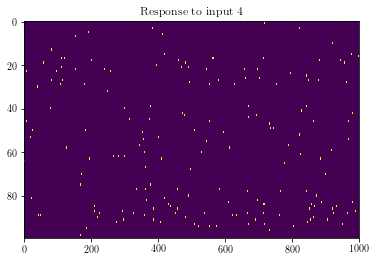

In [5]:
# Try reading it back....
import requests
import os
metadata = requests.get(HTTPS_PROTOCOL + os.getenv('S3_ENDPOINT') + '/' + BUCKET_PATH + "metadata.json").json()
dataset_train = metadata['train_examples_name']
dataset_test = metadata['test_examples_name']
    
dataset_train = metadata['train_examples_name']
dataset_test = metadata['test_examples_name']

def parse_one_example(example):
    example = tf.parse_single_example(example, features = {
        "example": tf.FixedLenFeature([], tf.string),
        "label": tf.FixedLenFeature([], tf.int64)
    })
    bits = tf.decode_raw(example['example'], tf.uint8)
    timeseries = np.unpackbits(bits).reshape((metadata['recording_time'],
                                              metadata['number_of_cells']))
    return timeseries, tf.one_hot(example['label'], len(metadata['labels']))

training_dataset = tf.data.TFRecordDataset([dataset_train])
test_dataset = tf.data.TFRecordDataset([dataset_test])

# Extract and display first image
# https://www.tensorflow.org/api_guides/python/image#Encoding_and_Decoding
example, label = parse_one_example(training_dataset.make_one_shot_iterator().get_next())

plt.figure()
print(label.numpy().astype(np.bool))
plt.imshow(example, aspect='auto')
plt.title('Response to input {}'.format(np.array(metadata['labels'])[label.numpy().astype(np.bool)][0]))